## Imports

In [1]:
from time import sleep
import librosa
import numpy as np
import sounddevice as sd
from speech_bandwidth_expansion.sbe_system.SpeechBandwidthExtension.sbe import SpeechBandwidthExtension
import matplotlib.pyplot as plt

## Apply Bandwidth Expansion and load other signals for comparison

In [2]:
filepath = "../data/GeorgeManos/sample2.wav"

sbe = SpeechBandwidthExtension(filepath)
sig, fs = sbe.produce_wideband_speech()
S_wb, fs_wb = librosa.load(filepath, sr=16000)
S_nb, fs_nb = sbe.S_nb, sbe.fs_nb
sig_interp, fs_interp = sbe.upsample_signal()

# Zero imputation for fair comparisson
sig = np.concatenate([sig, np.zeros((abs(len(sig) - len(S_wb))))])

## Listen to the signals!

In [ ]:
# Narrowband signal:
sd.play(S_nb, fs_nb)
sleep(len(S_nb) / fs_nb + 1)

# # Wideband signal:
sd.play(S_wb, fs_wb)
sleep(len(S_wb) / fs_wb + 1)

# Reconstructed wideband:
sd.play(sig, fs)
sleep(len(sig) / fs + 1)

# Simply interpolated
sd.play(sig_interp, fs_interp)
sleep(len(sig_interp) / fs_interp + 1)

## Compute Mean Squared Error (MSE)

In [3]:
MSE = np.power((S_wb - sig_interp), 2).mean()
print('Interpolated Signal MSE:', MSE)

Interpolated Signal MSE: 5.835726e-05


In [4]:
MSE = np.power((S_wb - sig), 2).mean()
print('SBE Signal MSE:', MSE)

SBE Signal MSE: 0.0028345062643864403


## Plot signals in time domain

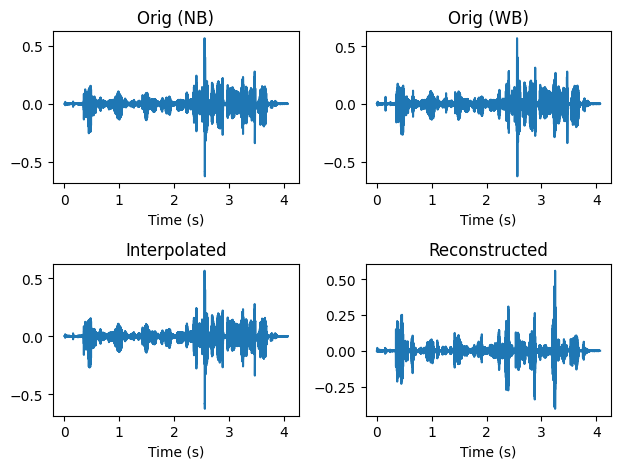

In [5]:
t_nb = np.arange(start=0, stop=len(S_nb)) / fs_nb
t_wb = np.arange(start=0, stop=len(S_wb)) / fs_wb

plt.figure()
plt.subplot(2,2,1)
plt.plot(t_nb, S_nb)
plt.title('Orig (NB)')
plt.xlabel('Time (s)')

plt.subplot(2,2,2)
plt.plot(t_wb, S_wb)
plt.title('Orig (WB)')
plt.xlabel('Time (s)')

plt.subplot(2,2,3)
plt.plot(t_wb, sig_interp)
plt.title('Interpolated')
plt.xlabel('Time (s)')

plt.subplot(2,2,4)
plt.plot(t_wb, sig)
plt.title('Reconstructed')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

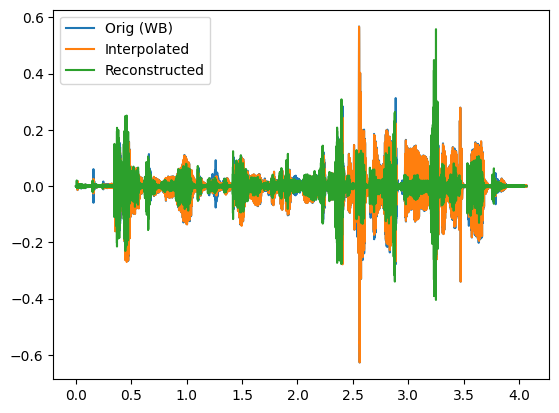

In [6]:
t_wb = np.arange(start=0, stop=len(S_wb)) / fs_wb

plt.figure()
plt.plot(t_wb, S_wb, label='Orig (WB)')
plt.plot(t_wb, sig_interp, label='Interpolated')
plt.plot(t_wb, sig, label='Reconstructed')
plt.legend()
plt.show()

# Compare Spectrograms

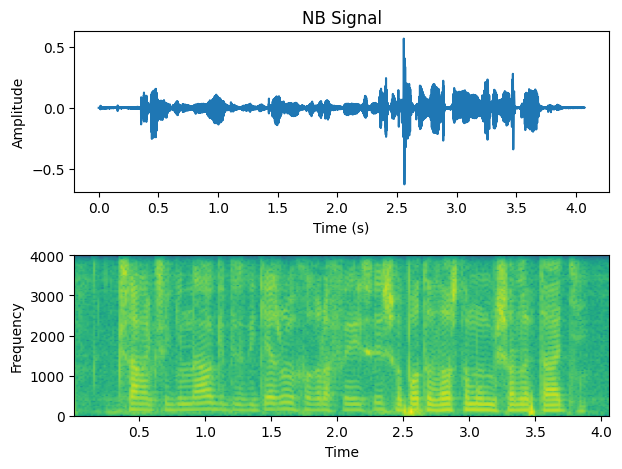

In [11]:
sbe.plot_spectrogram(sig=S_nb, fs=fs_nb, title='NB Signal')

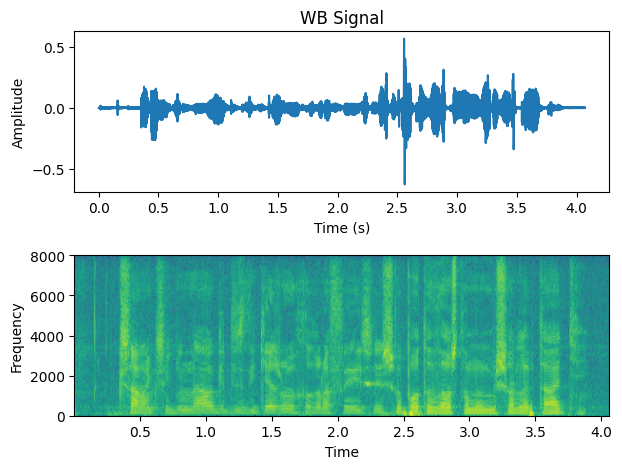

In [8]:
sbe.plot_spectrogram(sig=S_wb, fs=fs_wb, title='WB Signal')

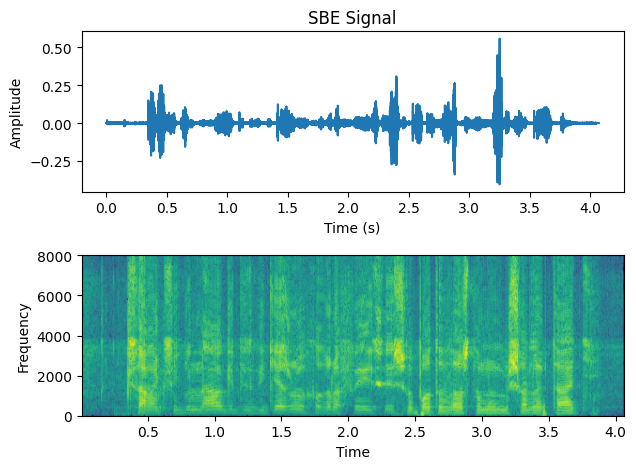

In [9]:
sbe.plot_spectrogram(sig=sig, fs=fs, title='SBE Signal')

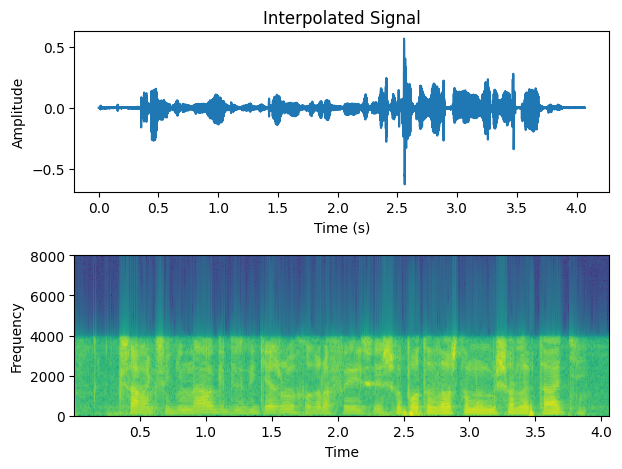

In [10]:
sbe.plot_spectrogram(sig=sig_interp, fs=fs_interp, title='Interpolated Signal')